In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [12]:
label = 'T0.71_N4_RHO0.844'

In [13]:
data = pd.read_csv(f'../output_files/{label}_positions_data.txt', sep=' ', names=['particle', 'time', 'x', 'y', 'z'])

In [14]:
unique_times = data['time'].unique()

msd_all_shifts = pd.DataFrame()
for start_time in unique_times:
    shifted_data = data[data['time'] >= start_time].copy()

    shifted_data['initial_x'] = shifted_data.groupby('particle')['x'].transform('first')
    shifted_data['initial_y'] = shifted_data.groupby('particle')['y'].transform('first')
    shifted_data['initial_z'] = shifted_data.groupby('particle')['z'].transform('first')

    shifted_data['squared_displacement'] = (
        (shifted_data['x'] - shifted_data['initial_x'])**2 +
        (shifted_data['y'] - shifted_data['initial_y'])**2 +
        (shifted_data['z'] - shifted_data['initial_z'])**2
    )

    # group by the shifted time and get mean
    msd_shift = shifted_data.groupby('time')['squared_displacement'].mean().rename(f'msd_start_{start_time}')

    if msd_all_shifts.empty:
        msd_all_shifts = msd_shift.to_frame()
    else:
        msd_all_shifts = msd_all_shifts.join(msd_shift, how='outer')

msd_all_shifts['msd_mean'] = msd_all_shifts.mean(axis=1)
msd_results = msd_all_shifts['msd_mean'].reset_index()

In [15]:
dimension = 3
slope, intercept, r_value, p_value, std_err = stats.linregress(msd_results['time'], msd_results['msd_mean'])
diffusion_constant = slope / (2 * dimension)

print("D:", diffusion_constant)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)

D: 0.002412422099298905
Slope: 0.01447453259579343
Intercept: 19.443770126455725
R-squared: 0.2056867755962397


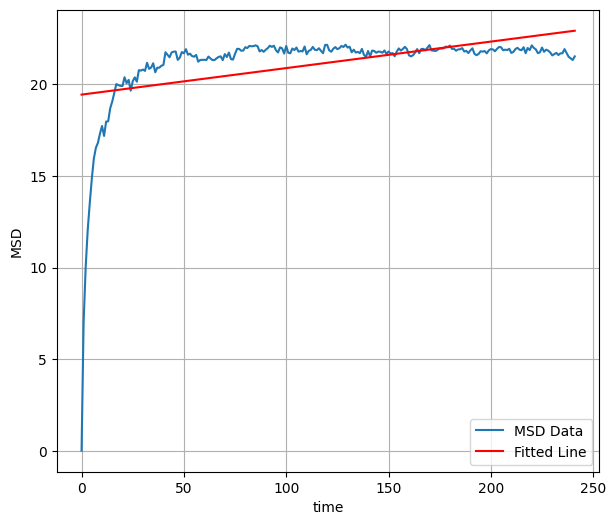

In [16]:
plt.figure(figsize=(7, 6))  

plt.plot(msd_results.time, msd_results.msd_mean, label='MSD Data')
plt.plot(msd_results['time'], intercept + slope * msd_results['time'], 'r', label='Fitted Line')

plt.xlabel('time')
plt.ylabel('MSD')

plt.legend()
plt.grid()
plt.show()